In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:


!mkdir /kaggle/working/Corn
!mkdir /kaggle/working/Corn/test
!mkdir /kaggle/working/Corn/train

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Corn* /kaggle/working/Corn/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Corn* /kaggle/working/Corn/train



transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
    ])

train_path='/kaggle/working/Corn/train'
test_path='/kaggle/working/Corn/test'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_dataset=ImageFolder(test_path,transform=transfrom)
train_dataset=ImageFolder(train_path,transform=transfrom)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# dataset=ImageFolder(path,transform=transfrom)

# train_dataset,test_dataset=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

batch_size = 32
n_iters = 20000
num_epochs = n_iters / (len(train_dataset) / batch_size)

# train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)

# val_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
from torch.autograd import Variable
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
#         self.mish1 = nn.Mish()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()
#         self.mish2 = nn.Mish()
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*112*112, 4)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
#         out = self.mish1(out)
        out = self.maxpool(out)
#         out = self.cnn2(out)
#         out = self.relu2(out)
#         out = self.mish2(out)
#         out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
model = NeuralNetwork()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer_ft = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [4]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [5]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [6]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

# optimizer_ft = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
# epochs=40
for epoch in range(1,int(num_epochs)+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 386/386 [00:39<00:00,  9.66it/s]


Train Loss: 0.581 | Accuracy: 76.524


100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


Test Loss: 0.378 | Accuracy: 85.371

Epoch : 2


100%|██████████| 386/386 [00:34<00:00, 11.35it/s]


Train Loss: 0.399 | Accuracy: 82.817


100%|██████████| 97/97 [00:08<00:00, 10.81it/s]


Test Loss: 0.392 | Accuracy: 84.655

Epoch : 3


100%|██████████| 386/386 [00:34<00:00, 11.33it/s]


Train Loss: 0.358 | Accuracy: 84.252


100%|██████████| 97/97 [00:08<00:00, 11.81it/s]


Test Loss: 0.327 | Accuracy: 86.964

Epoch : 4


100%|██████████| 386/386 [00:34<00:00, 11.33it/s]


Train Loss: 0.346 | Accuracy: 85.031


100%|██████████| 97/97 [00:08<00:00, 11.44it/s]


Test Loss: 0.320 | Accuracy: 86.964

Epoch : 5


100%|██████████| 386/386 [00:34<00:00, 11.35it/s]


Train Loss: 0.336 | Accuracy: 85.282


100%|██████████| 97/97 [00:07<00:00, 12.15it/s]


Test Loss: 0.347 | Accuracy: 85.728

Epoch : 6


100%|██████████| 386/386 [00:34<00:00, 11.19it/s]


Train Loss: 0.327 | Accuracy: 85.988


100%|██████████| 97/97 [00:08<00:00, 10.82it/s]


Test Loss: 0.336 | Accuracy: 84.883

Epoch : 7


100%|██████████| 386/386 [00:34<00:00, 11.29it/s]


Train Loss: 0.318 | Accuracy: 86.328


100%|██████████| 97/97 [00:08<00:00, 11.91it/s]


Test Loss: 0.282 | Accuracy: 88.231

Epoch : 8


100%|██████████| 386/386 [00:34<00:00, 11.28it/s]


Train Loss: 0.309 | Accuracy: 86.296


100%|██████████| 97/97 [00:08<00:00, 11.60it/s]


Test Loss: 0.298 | Accuracy: 87.289

Epoch : 9


100%|██████████| 386/386 [00:34<00:00, 11.34it/s]


Train Loss: 0.315 | Accuracy: 86.636


100%|██████████| 97/97 [00:09<00:00, 10.75it/s]


Test Loss: 0.304 | Accuracy: 87.354

Epoch : 10


100%|██████████| 386/386 [00:34<00:00, 11.29it/s]


Train Loss: 0.302 | Accuracy: 86.799


100%|██████████| 97/97 [00:08<00:00, 11.64it/s]


Test Loss: 0.284 | Accuracy: 87.874

Epoch : 11


100%|██████████| 386/386 [00:33<00:00, 11.41it/s]


Train Loss: 0.302 | Accuracy: 86.953


100%|██████████| 97/97 [00:08<00:00, 11.89it/s]


Test Loss: 0.290 | Accuracy: 87.874

Epoch : 12


100%|██████████| 386/386 [00:33<00:00, 11.38it/s]


Train Loss: 0.298 | Accuracy: 87.228


100%|██████████| 97/97 [00:08<00:00, 11.58it/s]


Test Loss: 0.290 | Accuracy: 88.264

Epoch : 13


100%|██████████| 386/386 [00:33<00:00, 11.46it/s]


Train Loss: 0.291 | Accuracy: 87.342


100%|██████████| 97/97 [00:08<00:00, 11.15it/s]


Test Loss: 0.278 | Accuracy: 88.719

Epoch : 14


100%|██████████| 386/386 [00:34<00:00, 11.34it/s]


Train Loss: 0.293 | Accuracy: 87.261


100%|██████████| 97/97 [00:08<00:00, 11.62it/s]


Test Loss: 0.323 | Accuracy: 86.899

Epoch : 15


100%|██████████| 386/386 [00:34<00:00, 11.29it/s]


Train Loss: 0.282 | Accuracy: 87.942


100%|██████████| 97/97 [00:08<00:00, 11.85it/s]


Test Loss: 0.277 | Accuracy: 88.817

Epoch : 16


100%|██████████| 386/386 [00:34<00:00, 11.28it/s]


Train Loss: 0.291 | Accuracy: 87.520


100%|██████████| 97/97 [00:08<00:00, 10.88it/s]


Test Loss: 0.308 | Accuracy: 87.289

Epoch : 17


100%|██████████| 386/386 [00:34<00:00, 11.34it/s]


Train Loss: 0.284 | Accuracy: 87.910


100%|██████████| 97/97 [00:08<00:00, 11.66it/s]


Test Loss: 0.289 | Accuracy: 88.394

Epoch : 18


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.280 | Accuracy: 88.088


100%|██████████| 97/97 [00:08<00:00, 11.72it/s]


Test Loss: 0.274 | Accuracy: 88.979

Epoch : 19


100%|██████████| 386/386 [00:34<00:00, 11.27it/s]


Train Loss: 0.272 | Accuracy: 88.453


100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


Test Loss: 0.260 | Accuracy: 89.337

Epoch : 20


100%|██████████| 386/386 [00:34<00:00, 11.33it/s]


Train Loss: 0.271 | Accuracy: 88.355


100%|██████████| 97/97 [00:08<00:00, 11.13it/s]


Test Loss: 0.275 | Accuracy: 88.492

Epoch : 21


100%|██████████| 386/386 [00:33<00:00, 11.41it/s]


Train Loss: 0.264 | Accuracy: 88.769


100%|██████████| 97/97 [00:08<00:00, 11.96it/s]


Test Loss: 0.262 | Accuracy: 88.687

Epoch : 22


100%|██████████| 386/386 [00:33<00:00, 11.40it/s]


Train Loss: 0.266 | Accuracy: 88.939


100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


Test Loss: 0.251 | Accuracy: 89.987

Epoch : 23


100%|██████████| 386/386 [00:33<00:00, 11.36it/s]


Train Loss: 0.253 | Accuracy: 89.045


100%|██████████| 97/97 [00:09<00:00, 10.75it/s]


Test Loss: 0.242 | Accuracy: 90.930

Epoch : 24


100%|██████████| 386/386 [00:33<00:00, 11.48it/s]


Train Loss: 0.253 | Accuracy: 89.215


100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


Test Loss: 0.251 | Accuracy: 89.597

Epoch : 25


100%|██████████| 386/386 [00:34<00:00, 11.33it/s]


Train Loss: 0.257 | Accuracy: 89.110


100%|██████████| 97/97 [00:08<00:00, 11.50it/s]


Test Loss: 0.257 | Accuracy: 89.402

Epoch : 26


100%|██████████| 386/386 [00:33<00:00, 11.44it/s]


Train Loss: 0.244 | Accuracy: 89.758


100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


Test Loss: 0.275 | Accuracy: 88.817

Epoch : 27


100%|██████████| 386/386 [00:33<00:00, 11.41it/s]


Train Loss: 0.253 | Accuracy: 89.320


100%|██████████| 97/97 [00:08<00:00, 11.19it/s]


Test Loss: 0.278 | Accuracy: 89.109

Epoch : 28


100%|██████████| 386/386 [00:33<00:00, 11.52it/s]


Train Loss: 0.251 | Accuracy: 89.556


100%|██████████| 97/97 [00:08<00:00, 11.85it/s]


Test Loss: 0.284 | Accuracy: 88.557

Epoch : 29


100%|██████████| 386/386 [00:33<00:00, 11.39it/s]


Train Loss: 0.244 | Accuracy: 89.742


100%|██████████| 97/97 [00:08<00:00, 11.78it/s]


Test Loss: 0.236 | Accuracy: 90.962

Epoch : 30


100%|██████████| 386/386 [00:33<00:00, 11.47it/s]


Train Loss: 0.234 | Accuracy: 90.123


100%|██████████| 97/97 [00:09<00:00, 10.69it/s]


Test Loss: 0.241 | Accuracy: 91.125

Epoch : 31


100%|██████████| 386/386 [00:33<00:00, 11.46it/s]


Train Loss: 0.237 | Accuracy: 90.066


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 0.239 | Accuracy: 90.800

Epoch : 32


100%|██████████| 386/386 [00:33<00:00, 11.47it/s]


Train Loss: 0.245 | Accuracy: 89.507


100%|██████████| 97/97 [00:08<00:00, 12.04it/s]


Test Loss: 0.259 | Accuracy: 90.215

Epoch : 33


100%|██████████| 386/386 [00:33<00:00, 11.35it/s]


Train Loss: 0.236 | Accuracy: 90.083


100%|██████████| 97/97 [00:07<00:00, 12.26it/s]


Test Loss: 0.261 | Accuracy: 89.434

Epoch : 34


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.245 | Accuracy: 89.620


100%|██████████| 97/97 [00:08<00:00, 10.92it/s]


Test Loss: 0.273 | Accuracy: 88.882

Epoch : 35


100%|██████████| 386/386 [00:33<00:00, 11.46it/s]


Train Loss: 0.237 | Accuracy: 90.229


100%|██████████| 97/97 [00:08<00:00, 11.74it/s]


Test Loss: 0.266 | Accuracy: 89.499

Epoch : 36


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.230 | Accuracy: 90.545


100%|██████████| 97/97 [00:08<00:00, 11.79it/s]


Test Loss: 0.245 | Accuracy: 90.052

Epoch : 37


100%|██████████| 386/386 [00:33<00:00, 11.38it/s]


Train Loss: 0.242 | Accuracy: 89.848


100%|██████████| 97/97 [00:08<00:00, 10.90it/s]


Test Loss: 0.234 | Accuracy: 91.190

Epoch : 38


100%|██████████| 386/386 [00:33<00:00, 11.55it/s]


Train Loss: 0.232 | Accuracy: 90.269


100%|██████████| 97/97 [00:08<00:00, 11.92it/s]


Test Loss: 0.247 | Accuracy: 89.987

Epoch : 39


100%|██████████| 386/386 [00:33<00:00, 11.39it/s]


Train Loss: 0.229 | Accuracy: 90.610


100%|██████████| 97/97 [00:07<00:00, 12.29it/s]


Test Loss: 0.298 | Accuracy: 87.451

Epoch : 40


100%|██████████| 386/386 [00:34<00:00, 11.33it/s]


Train Loss: 0.235 | Accuracy: 90.172


100%|██████████| 97/97 [00:08<00:00, 11.69it/s]


Test Loss: 0.244 | Accuracy: 89.369

Epoch : 41


100%|██████████| 386/386 [00:34<00:00, 11.34it/s]


Train Loss: 0.229 | Accuracy: 90.683


100%|██████████| 97/97 [00:08<00:00, 11.20it/s]


Test Loss: 0.228 | Accuracy: 91.515

Epoch : 42


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.233 | Accuracy: 90.399


100%|██████████| 97/97 [00:08<00:00, 11.65it/s]


Test Loss: 0.248 | Accuracy: 90.312

Epoch : 43


100%|██████████| 386/386 [00:33<00:00, 11.44it/s]


Train Loss: 0.224 | Accuracy: 90.772


100%|██████████| 97/97 [00:08<00:00, 11.80it/s]


Test Loss: 0.228 | Accuracy: 91.385

Epoch : 44


100%|██████████| 386/386 [00:33<00:00, 11.51it/s]


Train Loss: 0.231 | Accuracy: 90.480


100%|██████████| 97/97 [00:09<00:00, 10.39it/s]


Test Loss: 0.270 | Accuracy: 89.207

Epoch : 45


100%|██████████| 386/386 [00:33<00:00, 11.39it/s]


Train Loss: 0.228 | Accuracy: 90.642


100%|██████████| 97/97 [00:07<00:00, 12.27it/s]


Test Loss: 0.239 | Accuracy: 90.962

Epoch : 46


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.230 | Accuracy: 90.634


100%|██████████| 97/97 [00:08<00:00, 11.67it/s]


Test Loss: 0.239 | Accuracy: 90.832

Epoch : 47


100%|██████████| 386/386 [00:33<00:00, 11.41it/s]


Train Loss: 0.223 | Accuracy: 90.642


100%|██████████| 97/97 [00:08<00:00, 10.86it/s]


Test Loss: 0.211 | Accuracy: 92.198

Epoch : 48


100%|██████████| 386/386 [00:33<00:00, 11.47it/s]


Train Loss: 0.220 | Accuracy: 90.869


100%|██████████| 97/97 [00:08<00:00, 11.29it/s]


Test Loss: 0.238 | Accuracy: 90.475

Epoch : 49


100%|██████████| 386/386 [00:33<00:00, 11.56it/s]


Train Loss: 0.224 | Accuracy: 90.602


100%|██████████| 97/97 [00:08<00:00, 11.82it/s]


Test Loss: 0.225 | Accuracy: 90.930

Epoch : 50


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.224 | Accuracy: 90.967


100%|██████████| 97/97 [00:08<00:00, 11.63it/s]


Test Loss: 0.220 | Accuracy: 91.450

Epoch : 51


100%|██████████| 386/386 [00:33<00:00, 11.42it/s]


Train Loss: 0.222 | Accuracy: 90.545


100%|██████████| 97/97 [00:08<00:00, 11.15it/s]

Test Loss: 0.241 | Accuracy: 89.922


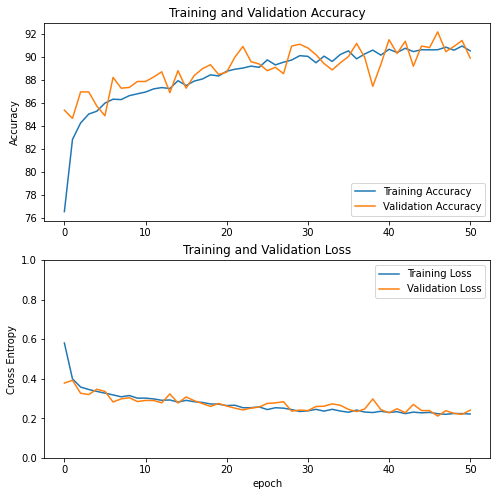

In [8]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [9]:
# !pip install playsound

# from playsound import playsound
  
# # for playing note.wav file
# playsound('/path/note.wav')
# print('playing sound using  playsound')

In [10]:
# import os, os.path

# # simple version for working with CWD
# print len([name for name in os.listdir('') if os.path.isfile(name)])

In [11]:
torch.save(AlexNet_model.state_dict(), '/kaggle/working/alexnet.pk1')

NameError: name 'AlexNet_model' is not defined

In [ ]:
model_scripted = torch.jit.script(AlexNet_model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

import os 
os.chdir(r'/kaggle/working')
from IPython.display import
FileLinkFileLink(r'AlexNet_model.pt')

import os 
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'alexnet.pk1')